# Definitions
Here we are analyze data from may solar stations. The output is:
- Select 2-3 stations from 5 different regions (Nordeste, Norte, Sul, Sudeste e Centro-Oeste)
- Made a singular EDA for each station
- At final, compare these stations among them and get conclusions

### Possíveis análises:
- Ver quais periodos do ano tem mais radiação entre as estações
- Confirmar se há relação entre as categorias criadas (hue) com a radiação
- Verificar quantidades de nulls por estação
- Verificar dispersão dos dados por estação
- Remoção de colunas (colunas do tipo "na estação", por exemplo)
- Feature engineering (juntar dois campos, criar campos category, etc)
- Coluna (std, mean, etc) por estação
- pd.crosstab

### Perguntas
- Qual  estação com mais nulls?
- Quais colunas são desnecessárias?

### Import das bibliotecas

In [331]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.special import expit
from pandas.errors import SettingWithCopyWarning
import os
from os import listdir
from os import system

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

### Aux methods

In [461]:
def getSigmoid():
    arr = np.arange(0, 1, 0.02)
    np.hstack(np.vstack(arr))
    def sigmoid(x):
        return 1/(1+expit(-x))
    
    sigmoid(arr)
    sns.scatterplot(x=arr, y=sigmoid(arr))

def get_files(n=1, lazy=True):
    cwd = os.getcwd()
    
    dict_data = {}
    
    listdir(cwd + "/data/estacoes_solares/BDM_INMET/")
    list_files = [x for x in listdir(cwd + "/data/estacoes_solares/BDM_INMET/") if ".csv" in x]

    if n:
        _range = list_files[0:n]
    else:
        _range = list_files
    
    for i in _range:
        # print("Processando arquivo " + i)
        
        code = i.split("_")[1]
        head = os.popen("head -10 data/estacoes_solares/BDM_INMET/" + i).read()

        if lazy:
            data = "data/estacoes_solares/BDM_INMET/"+i
        else:
            data = pd.read_csv("data/estacoes_solares/BDM_INMET/"+i, sep=";", skiprows=10)
        
        dict_data[code] = [head, data]

    return dict_data

def getDictToRenameDataFrame(list_columns):
    list_columns_new = []
    for i in list_columns: 
        list_columns_new.append(str
              .lower(i)
              .replace(" ", "_")
              . replace("(", "_")
              .replace(")", "")
              .replace("/", "")
              .replace("²", "2")
              .replace("°", "")
              .replace("%", "perc")
              .replace("._", "_")
              .replace(".", "_")
              .replace("__", "_")
              .replace("_-_", "_")
              .replace(",_", "_")
             )
    
    return dict(zip(list_columns, list_columns_new))

def renameDatasetColumns(df):
    list_columns = df.columns

    list_dict_to_rename = getDictToRenameDataFrame(list_columns)
    return df.rename(columns=list_dict_to_rename).drop(["unnamed:_22"], axis=1)

def hour_transform(n):
    if len(str(n)) == 4:
        return str(n)[0:2] + ":" + str(n)[2:] + ":00"
    elif len(str(n)) == 3:
        return "0" + str(n)[0:1] + ":" + str(n)[1:] + ":00"
    elif n == 0:
        return "00:00:00"

def create_datetime_feature(df):
    df["hora_medicao"] = df["hora_medicao"].apply(hour_transform)
    df["data_hora_str"] = df["data_medicao"] + " " + df["hora_medicao"]
    df["data_hora"] = pd.to_datetime(df["data_hora_str"])
    df["hora"] = df['data_hora'].dt.hour
    
    return df.drop(["data_hora_str"], axis=1)

def create_split_date_features(df):
    df["dia"] = df["data_hora"].dt.day
    df["mes"] = df["data_hora"].dt.month
    df["ano"] = df["data_hora"].dt.year

    return df

def create_category(column, df):
    labels = ["A", "B", "C", "D"]
    classes = df.describe()[column][3:8].values

    if classes[1] == 0:
        classes[1] = classes[1]+0.1
        print("aqui")
    print(classes)
    
    return pd.cut(x = df[column],
         bins = classes,
         labels = labels,
         include_lowest = True)

def removeNulls(df, col):
    return df[df[col].notnull()]

def pre_processing(df):
    renameDatasetColumns(df)

def load(path):
    return pd.read_csv(path, sep=";", skiprows=10)

def get_perc_nulls(df):
    return (df.isnull().sum()/(len(df)))*100

### Getting data
Here we can get as much as we can, just passing the arg `n` with the number of files we want to load. The return is the file itself (index 1) and the head with more information about the file (index 0)

In [333]:
dict_data = get_files(n=None)

In [334]:
print(dict_data.keys())

dict_keys(['A316', 'A419', 'A853', 'A372', 'A326', 'A225', 'A348', 'A207', 'A319', 'A430', 'A358', 'A440', 'A305', 'A337', 'A340', 'A204', 'B806', 'A825', 'A446', 'A338', 'A331', 'A872', 'A301', 'A350', 'A330', 'A823', 'A333', 'A322', 'A821', 'A828', 'A346', 'A318', 'A349', 'A336', 'A343', 'A441', 'A308', 'A220', 'A411', 'A313', 'A846', 'A855', 'A237', 'A820', 'A874', 'A450', 'A218', 'A405', 'A341', 'A444', 'A436', 'A811', 'A363', 'A352', 'A217', 'A351', 'A320', 'A239', 'A224', 'A449', 'A205', 'A873', 'A409', 'A221', 'A843', 'A304', 'A238', 'A812', 'A055', 'A317', 'A807', 'A357', 'A345', 'A133', 'A437', 'A310', 'A452', 'A818', 'A835', 'A203', 'A822', 'A424', 'A407', 'A365', 'A404', 'A354', 'A417', 'A455', 'A328', 'A377', 'A309', 'A438', 'A306', 'A849', 'A206', 'A359', 'A361', 'A842', 'A824', 'A307', 'A420', 'A054', 'A219', 'B803', 'A127', 'A826', 'A332', 'A375', 'A362', 'B804', 'A311', 'A414', 'A827', 'A223', 'A329', 'A423', 'A875', 'A344', 'A840', 'A819', 'A850', 'A222', 'A401', 'A324

# A316
Randomly getting this station from Rio Grande do Norte (RN)

In [335]:
print(dict_data["A316"][0])

Nome: CAICO
Codigo Estacao: A316
Latitude: -6.46749999
Longitude: -37.08499999
Altitude: 171.26
Situacao: Operante
Data Inicial: 2007-01-06
Data Final: 2023-09-10
Periodicidade da Medicao: Horaria




### Renaming the dataset
Here we will just rename the columns in order to get a more organised dataset

In [336]:
df_a316 = renameDatasetColumns(load(dict_data["A316"][1]))

### Showing info data

In [337]:
df_a316.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146208 entries, 0 to 146207
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   data_medicao                                        146208 non-null  object 
 1   hora_medicao                                        146208 non-null  int64  
 2   precipitacao_total_horario_mm                       114106 non-null  float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  120369 non-null  float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    120358 non-null  float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          120191 non-null  float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          120191 non-null  float64
 7   radiacao_global_kjm2                                120257 non-null  float64
 8   temperatura_da_cpu_da_estacao_c                     119607 non-n

A lot of nulls. In this case, lets remove the nulls based on theoretical more important feature, the radiation

In [441]:
get_perc_nulls(df_a316)

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                         21.956391
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb    17.672768
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb      17.680291
pressao_atmosferica_max_na_hora_ant_aut_mb            17.794512
pressao_atmosferica_min_na_hora_ant_aut_mb            17.794512
radiacao_global_kjm2                                  17.749371
temperatura_da_cpu_da_estacao_c                       18.193943
temperatura_do_ar_bulbo_seco_horaria_c                17.673452
temperatura_do_ponto_de_orvalho_c                     17.673452
temperatura_maxima_na_hora_ant_aut_c                  17.795880
temperatura_minima_na_hora_ant_aut_c                  17.795880
temperatura_orvalho_max_na_hora_ant_aut_c             17.795880
temperatura_orvalho_min_na_hora_ant_aut_c             17.795880
tensao_da_bateria_da_estacao_v          

### Removing null
Lets get the potential more valueable column: `radiacao_global_kjm2` 

In [341]:
df_a316_non_null = removeNulls(df_a316, "radiacao_global_kjm2")

### Creating datetime features

In [342]:
df_a316_non_null_dt = create_datetime_feature(df_a316_non_null)
df_a316_non_null_dt = create_split_date_features(df_a316_non_null_dt)

### Showing the data

In [343]:
df_a316_non_null_dt.head().T

,21,22,23,24,25
data_medicao,2007-01-06,2007-01-06,2007-01-06,2007-01-07,2007-01-07
hora_medicao,21:00:00,22:00:00,23:00:00,00:00:00,01:00:00
precipitacao_total_horario_mm,0.0,0.0,0.0,0.0,0.0
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,988.6,989.6,990.9,991.5,991.8
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,1007.88472,1009.006801,1010.423065,1011.113414,1011.478678
pressao_atmosferica_max_na_hora_ant_aut_mb,988.7,989.6,990.9,991.6,991.8
pressao_atmosferica_min_na_hora_ant_aut_mb,987.8,988.6,989.6,990.9,991.5
radiacao_global_kjm2,122.094,-3.53,-3.54,-3.503,-3.509
temperatura_da_cpu_da_estacao_c,NaN,NaN,NaN,NaN,NaN
temperatura_do_ar_bulbo_seco_horaria_c,32.5,30.9,29.5,28.3,27.4


In [445]:
df = df_a316_non_null_dt

In [ ]:
#plot hist
many_nulls_zeros = ["precipitacao_total_horario_mm"]

#plot hist
join_press = [
            "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", 
            "pressao_atmosferica_reduzida_nivel_do_mar_aut_mb",
            "pressao_atmosferica_max_na_hora_ant_aut_mb",
            "pressao_atmosferica_min_na_hora_ant_aut_mb"
       ]

#show it as additional information, cause it could be impacts in the nulls registration (as it grows, we have more nulls)
# df["temperatura_da_cpu_da_estacao_c"].plot.hist()
get_perc_nulls(df[df["temperatura_da_cpu_da_estacao_c"] >= 44])

mean_temp = ["temperatura_da_cpu_da_estacao_c", 
        "temperatura_maxima_na_hora_ant_aut_c",
        "temperatura_minima_na_hora_ant_aut_c"]

# Show it as add information (just plot the linear relation witht the radiation)
# temperatura_do_ar_bulbo_seco_horaria_c


without_relevance = ["temperatura_do_ponto_de_orvalho_c",
                 "temperatura_orvalho_max_na_hora_ant_aut_c",
                 "temperatura_orvalho_min_na_hora_ant_aut_c",
                 "tensao_da_bateria_da_estacao_v",
                  "vento_direcao_horaria_gr__gr",
                 "vento_velocidade_horaria_ms"]

#About the umidit, theres a roortional inverse relation 
# with the radiation (as the umidit grows, the radiation decrease). Check it with the hour of day 
mean_temp = ["umidade_rel_max_na_hora_ant_aut_perc",
            "umidade_rel_min_na_hora_ant_aut_perc",
            "umidade_relativa_do_ar_horaria_perc"]



### Some statistics

In [487]:
get_perc_nulls(df[df["umidade_relativa_do_ar_horaria_perc"] >= 70])

data_medicao                                          0.000000
hora_medicao                                          0.000000
precipitacao_total_horario_mm                         8.501832
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb    0.000000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb      0.000000
pressao_atmosferica_max_na_hora_ant_aut_mb            0.308726
pressao_atmosferica_min_na_hora_ant_aut_mb            0.308726
radiacao_global_kjm2                                  0.000000
temperatura_da_cpu_da_estacao_c                       0.376578
temperatura_do_ar_bulbo_seco_horaria_c                0.000000
temperatura_do_ponto_de_orvalho_c                     0.000000
temperatura_maxima_na_hora_ant_aut_c                  0.308726
temperatura_minima_na_hora_ant_aut_c                  0.308726
temperatura_orvalho_max_na_hora_ant_aut_c             0.308726
temperatura_orvalho_min_na_hora_ant_aut_c             0.308726
tensao_da_bateria_da_estacao_v                        0

In [455]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitacao_total_horario_mm,113994.0,0.058545,0.0,0.0,0.0,0.0,55.8,0.859526
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,120257.0,992.947482,983.6,991.3,993.0,994.7,1001.2,2.477146
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,120247.0,1012.57832,1002.673769,1010.856286,1012.632226,1014.43419,1021.063821,2.670703
pressao_atmosferica_max_na_hora_ant_aut_mb,120079.0,993.254154,984.0,991.6,993.3,994.9,1001.2,2.432824
pressao_atmosferica_min_na_hora_ant_aut_mb,120079.0,992.668084,983.5,991.0,992.7,994.4,1001.0,2.488053
radiacao_global_kjm2,120257.0,1027.399741,-7.02,-3.54,191.948,2114.761,4246.893,1247.990849
temperatura_da_cpu_da_estacao_c,119497.0,30.482255,19.0,27.0,30.0,34.0,44.0,4.688791
temperatura_do_ar_bulbo_seco_horaria_c,120257.0,28.527212,18.3,25.1,27.9,31.8,39.5,4.070311
temperatura_do_ponto_de_orvalho_c,120257.0,17.626213,2.2,15.7,17.9,19.9,26.3,3.214692
temperatura_maxima_na_hora_ant_aut_c,120079.0,29.193496,18.9,25.5,28.7,32.7,40.1,4.252992


<Axes: xlabel='umidade_relativa_do_ar_horaria_perc', ylabel='radiacao_global_kjm2'>

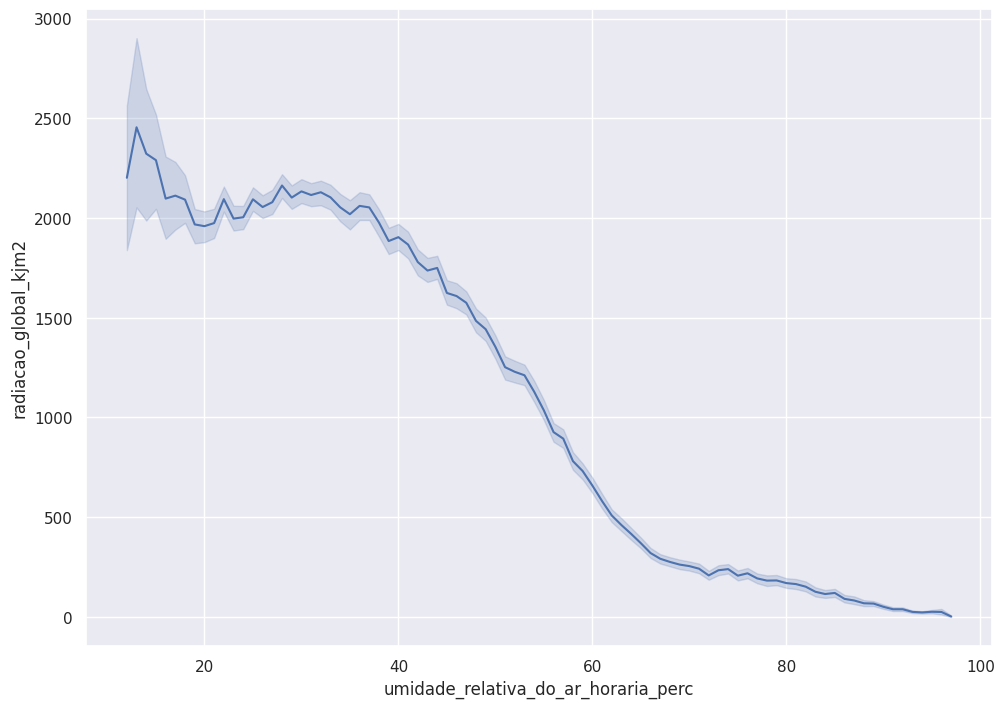

In [488]:
sns.lineplot(data=df, x=df["umidade_relativa_do_ar_horaria_perc"], y=df["radiacao_global_kjm2"])

### Date analisys
Here we will create a more short name to the dataframe. Then, we will plot the radiation by date

#### By year

In [345]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Mean and STD
Just to be sure if we not have a weird standard deviation, lets get the mean and std 

In [346]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2007,927.602872,1223.002190
2008,919.089730,1220.883743
2009,909.574677,1210.542371
2010,956.781121,1236.105146
2011,903.313209,1204.213752
2012,963.710995,1252.189307
2013,924.730284,1220.234966
2014,976.076605,1221.284738
2015,917.082689,1208.622795


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

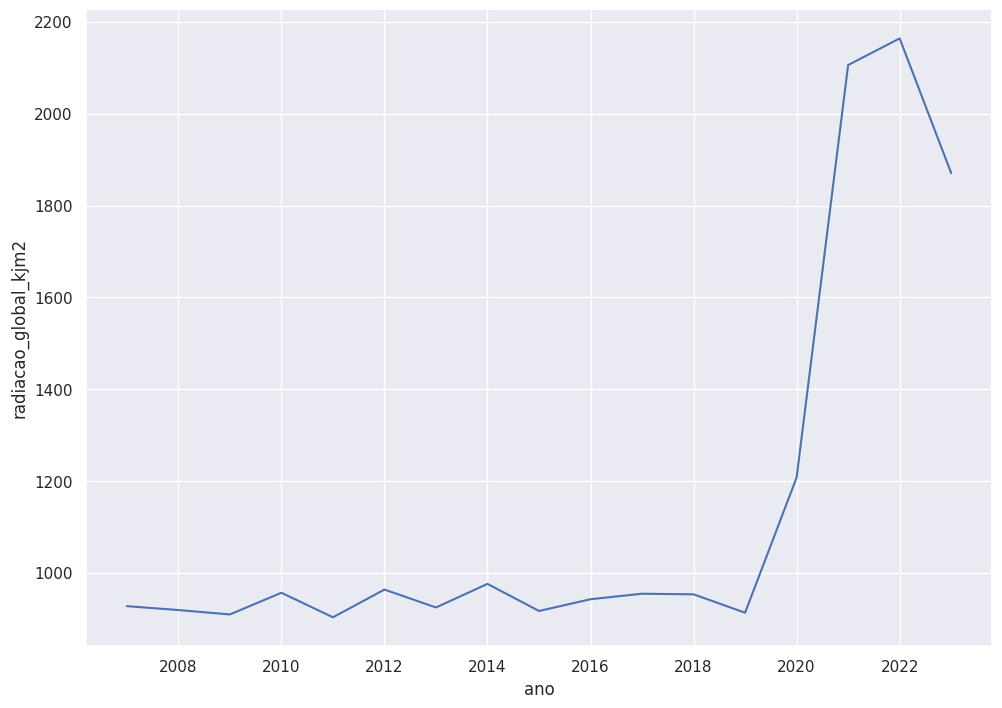

In [347]:
sns.lineplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### By month

In [348]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

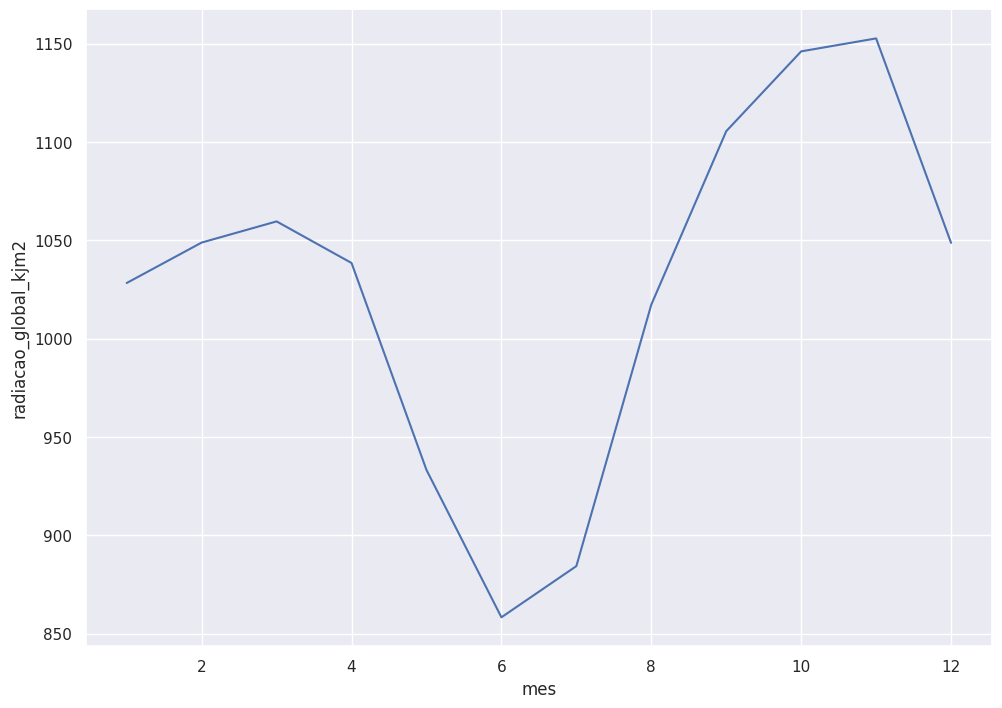

In [349]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### By hour

In [350]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

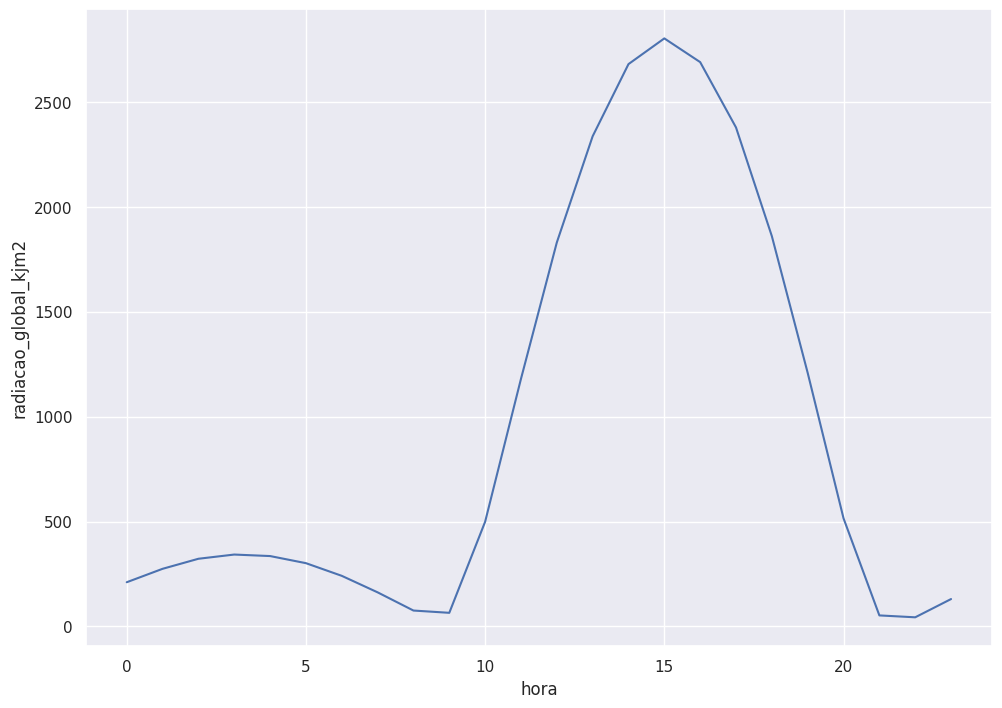

In [351]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### By hour with wind as hue

In [494]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_direcao_horaria_gr__gr"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_direcao_horaria_gr__gr", df_hour_wind)


[  0.  89. 106. 124. 360.]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

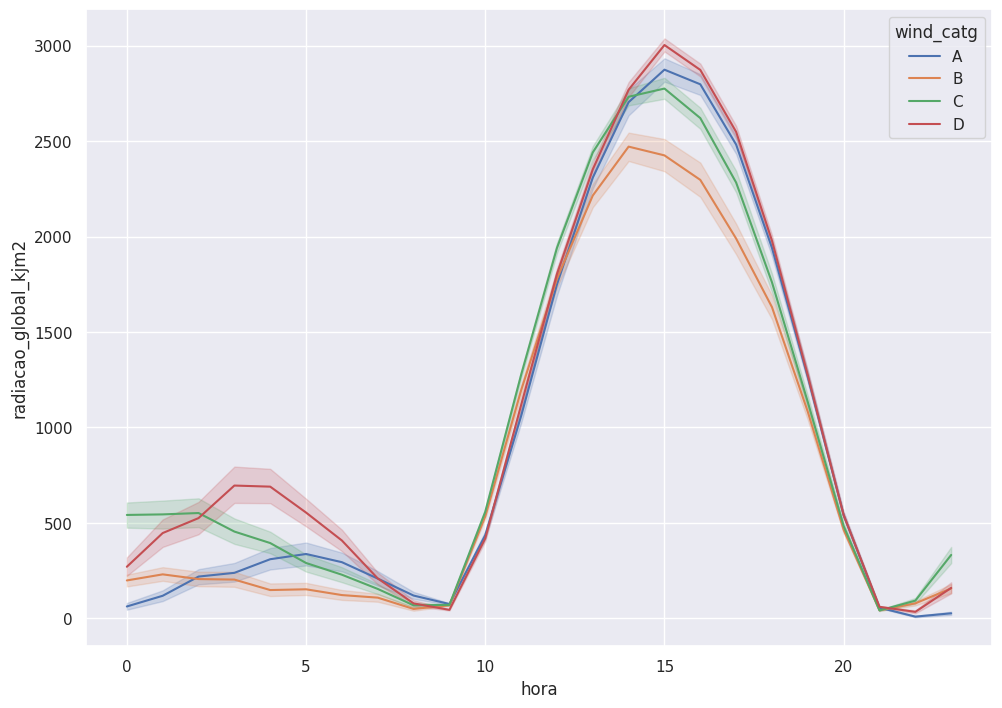

In [495]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### By hour with atmo press as hue

In [354]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", df_hour_press)

[ 983.6  991.3  993.   994.7 1001.2]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

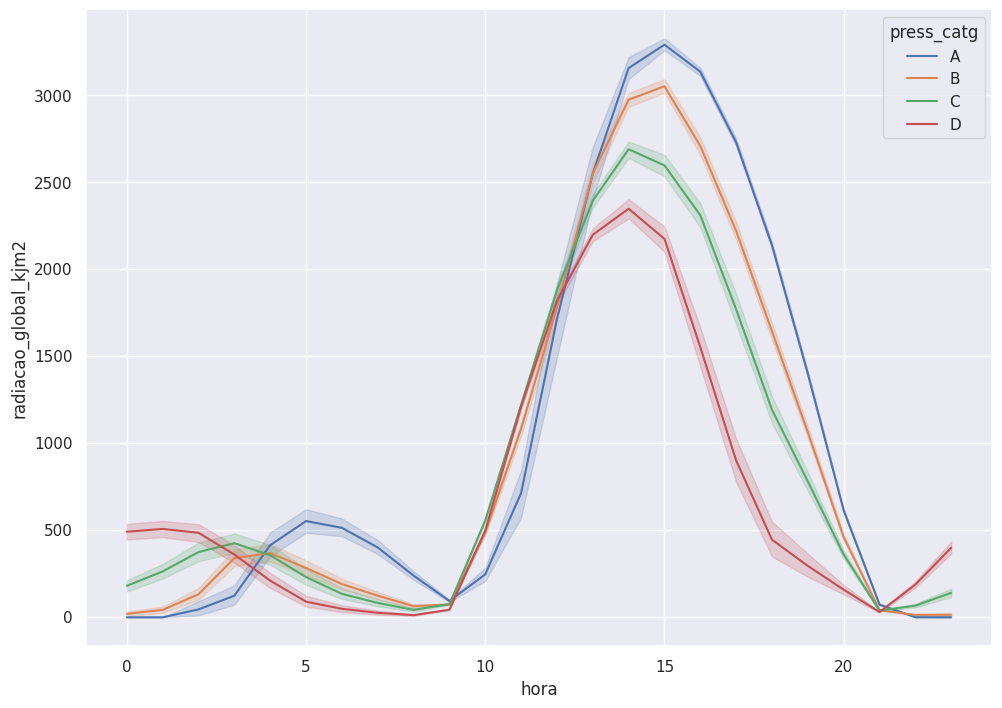

In [355]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

#### By hour with temp as hue

In [356]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "temperatura_maxima_na_hora_ant_aut_c"]]\
.fillna(0)

df_temp["temp_catg"] = create_category("temperatura_maxima_na_hora_ant_aut_c", df_temp)

[ 0.  25.5 28.7 32.7 40.1]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

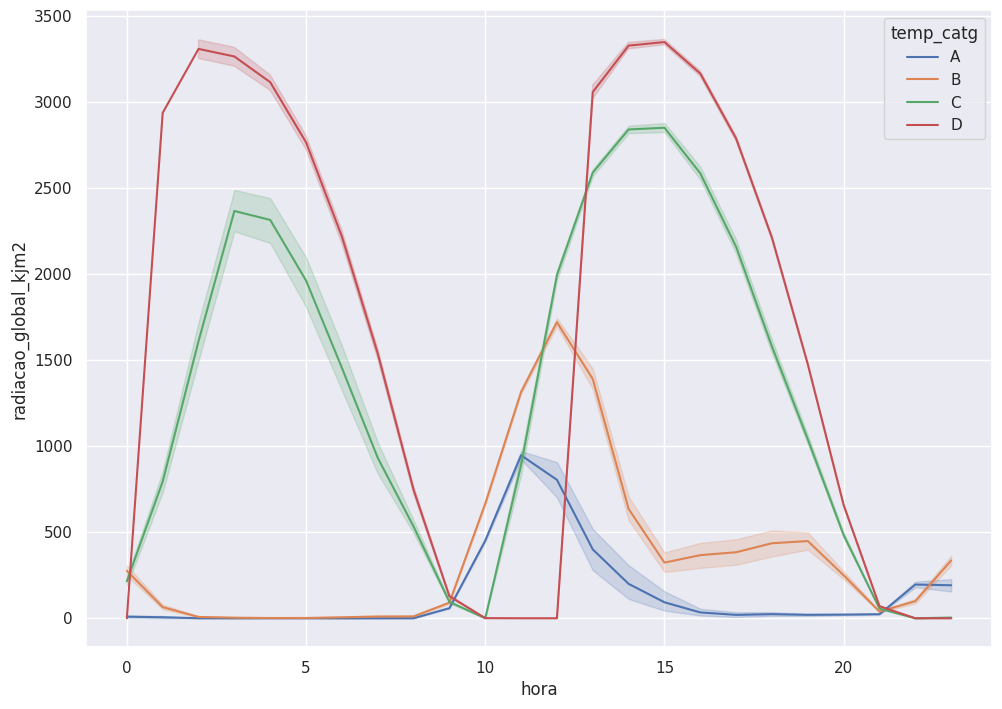

In [357]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["temp_catg"])

### Some notes
As we see, in the year plot theres not a high std witch could be explain the highest values in radiation since 2020. Lets check by month.

At the monht, thats make sense, once we have the sun nearest earth at the start nad end of the year. Lets check by hour.

And the hour, as the year, the hour plot make sense too, with the values we can see above. Lets check the wind speed as a possible `hue` parameter.

Apparently, as low the atmo press is, more raidation we have.

# A419
Again, randomly getting this station from Sergipe (SE)

In [358]:
print(dict_data["A419"][0])

Nome: POCO VERDE
Codigo Estacao: A419
Latitude: -10.73805555
Longitude: -38.10833333
Altitude: 367.01
Situacao: Operante
Data Inicial: 2008-04-02
Data Final: 2023-09-10
Periodicidade da Medicao: Horaria




### Renaming

In [359]:
df_a419 = renameDatasetColumns(load(dict_data["A419"][1]))

### Showing info data

In [360]:
df_a419.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135360 entries, 0 to 135359
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   data_medicao                                        135360 non-null  object 
 1   hora_medicao                                        135360 non-null  int64  
 2   precipitacao_total_horario_mm                       101458 non-null  float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  120450 non-null  float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    120440 non-null  float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          120286 non-null  float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          120286 non-null  float64
 7   radiacao_global_kjm2                                120338 non-null  float64
 8   temperatura_da_cpu_da_estacao_c                     120454 non-n

In [361]:
df_a419.describe().T

,count,mean,std,min,25%,50%,75%,max
hora_medicao,135360.0,1150.000000,692.221212,0.00000,575.000000,1150.00000,1725.000000,2300.000000
precipitacao_total_horario_mm,101458.0,0.067401,0.569678,0.00000,0.000000,0.00000,0.000000,55.000000
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,120450.0,972.563361,2.696135,961.60000,970.700000,972.50000,974.500000,981.500000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,120440.0,1014.645961,3.136661,1002.34451,1012.499929,1014.56776,1016.922023,1024.321934
pressao_atmosferica_max_na_hora_ant_aut_mb,120286.0,972.813962,2.671727,961.90000,970.900000,972.70000,974.700000,981.900000
pressao_atmosferica_min_na_hora_ant_aut_mb,120286.0,972.309044,2.706713,961.50000,970.400000,972.20000,974.200000,981.400000
radiacao_global_kjm2,120338.0,797.024097,1065.584085,-3.54000,-3.538000,42.59950,1545.244750,4371.247000
temperatura_da_cpu_da_estacao_c,120454.0,25.806706,4.525169,14.00000,22.000000,25.00000,29.000000,43.000000
temperatura_do_ar_bulbo_seco_horaria_c,120450.0,24.255502,3.938896,13.20000,21.400000,23.40000,26.800000,39.200000
temperatura_do_ponto_de_orvalho_c,117247.0,19.066194,1.998926,7.10000,17.900000,19.30000,20.400000,28.600000


In [362]:
(df_a419.isnull().sum()/(len(df_a319)))*100

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                         25.045804
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb    11.015071
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb      11.022459
pressao_atmosferica_max_na_hora_ant_aut_mb            11.136229
pressao_atmosferica_min_na_hora_ant_aut_mb            11.136229
radiacao_global_kjm2                                  11.097813
temperatura_da_cpu_da_estacao_c                       11.012116
temperatura_do_ar_bulbo_seco_horaria_c                11.015071
temperatura_do_ponto_de_orvalho_c                     13.381353
temperatura_maxima_na_hora_ant_aut_c                  11.136968
temperatura_minima_na_hora_ant_aut_c                  11.136968
temperatura_orvalho_max_na_hora_ant_aut_c             13.584515
temperatura_orvalho_min_na_hora_ant_aut_c             13.584515
tensao_da_bateria_da_estacao_v          

### Removing nulls

In [363]:
df_a419_non_null = removeNulls(df_a419, "radiacao_global_kjm2")

### Creating datetime features

In [364]:
df_a419_non_null_dt = create_datetime_feature(df_a419_non_null)
df_a419_non_null_dt = create_split_date_features(df_a419_non_null_dt)

### Showing the data

In [365]:
df_a419_non_null_dt.head().T

,44,45,46,47,48
data_medicao,2008-04-03,2008-04-03,2008-04-03,2008-04-03,2008-04-04
hora_medicao,20:00:00,21:00:00,22:00:00,23:00:00,00:00:00
precipitacao_total_horario_mm,0.0,0.0,0.0,0.0,0.0
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,966.9,967.6,968.0,968.7,969.2
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,1008.508833,1009.482174,1009.942722,1010.701946,1011.252573
pressao_atmosferica_max_na_hora_ant_aut_mb,966.9,967.6,968.0,968.7,969.2
pressao_atmosferica_min_na_hora_ant_aut_mb,966.6,966.9,967.5,968.0,968.7
radiacao_global_kjm2,858.116,57.528,-3.532,-3.54,-3.526
temperatura_da_cpu_da_estacao_c,29.0,27.0,25.0,25.0,24.0
temperatura_do_ar_bulbo_seco_horaria_c,25.8,24.1,23.8,23.6,23.4


### Date analisys

In [366]:
df = df_a419_non_null_dt

#### By year

In [367]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Mean and STD

In [368]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2008,742.856587,1020.901897
2009,774.472892,1058.505765
2010,768.282551,1049.174617
2011,799.495796,1061.452286
2012,812.434160,1079.576132
2013,806.707253,1086.506718
2014,763.533098,1033.977346
2015,828.138871,1111.019478
2016,798.218785,1071.187790


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

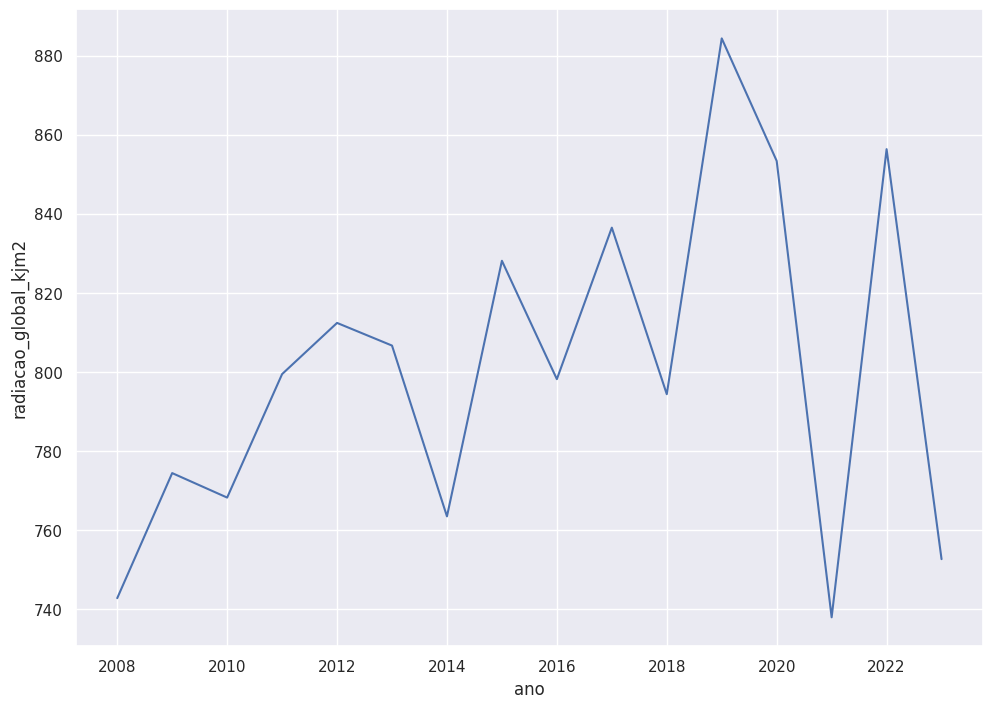

In [369]:
sns.lineplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### By month

In [370]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

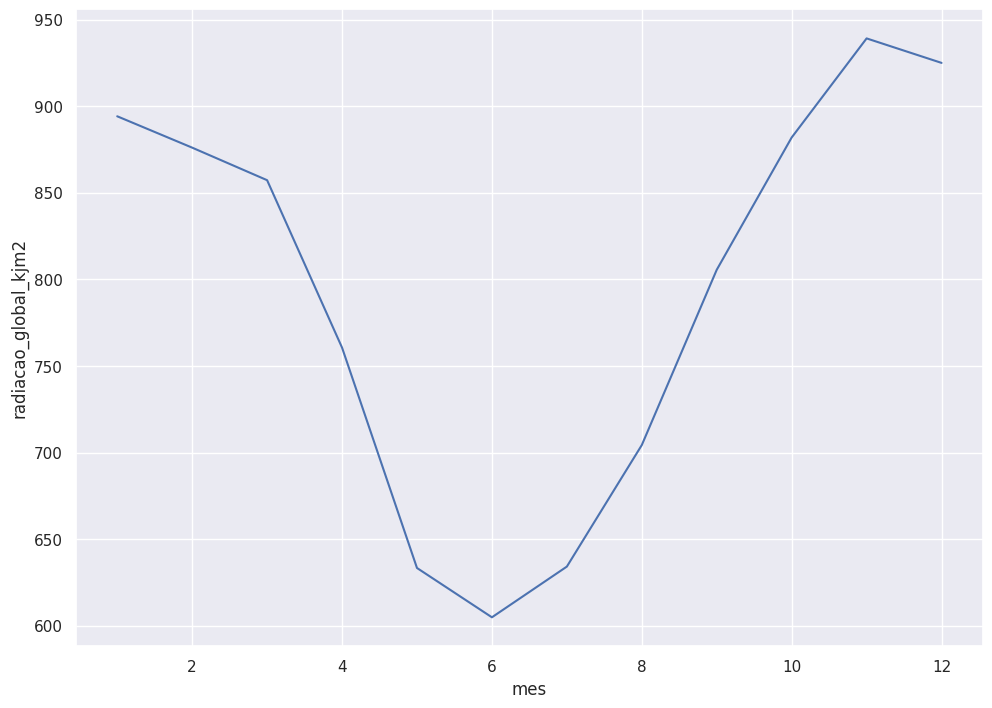

In [371]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### By hour

In [372]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

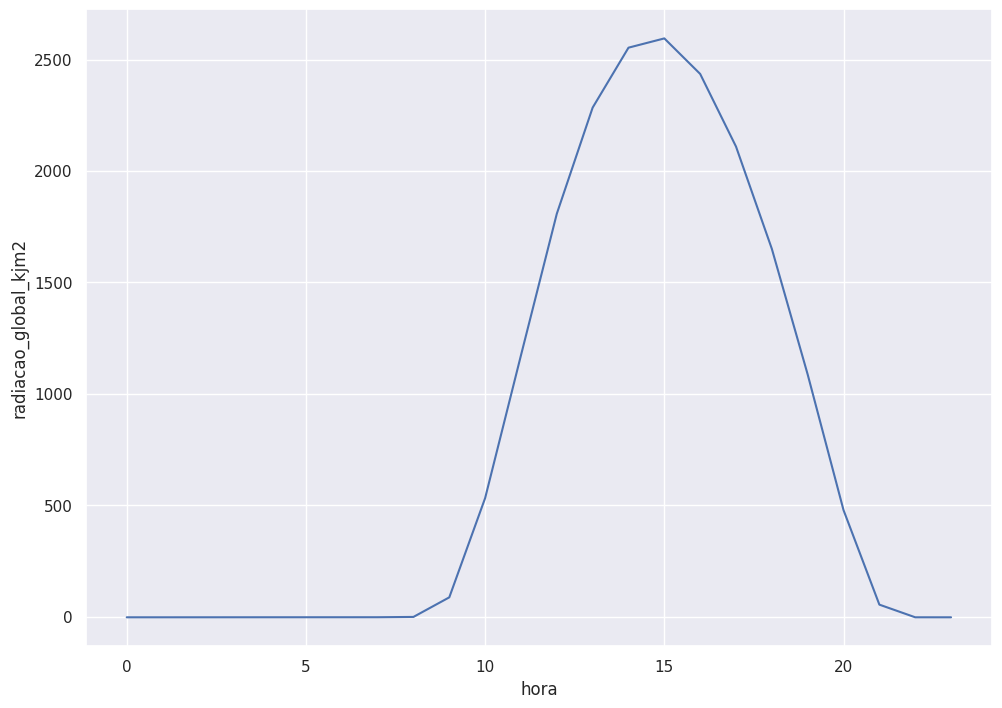

In [373]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### By hour with wind as hue

In [374]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_rajada_maxima_ms"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_rajada_maxima_ms", df_hour_wind)

aqui
[ 0.   0.1  6.   8.7 22.1]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

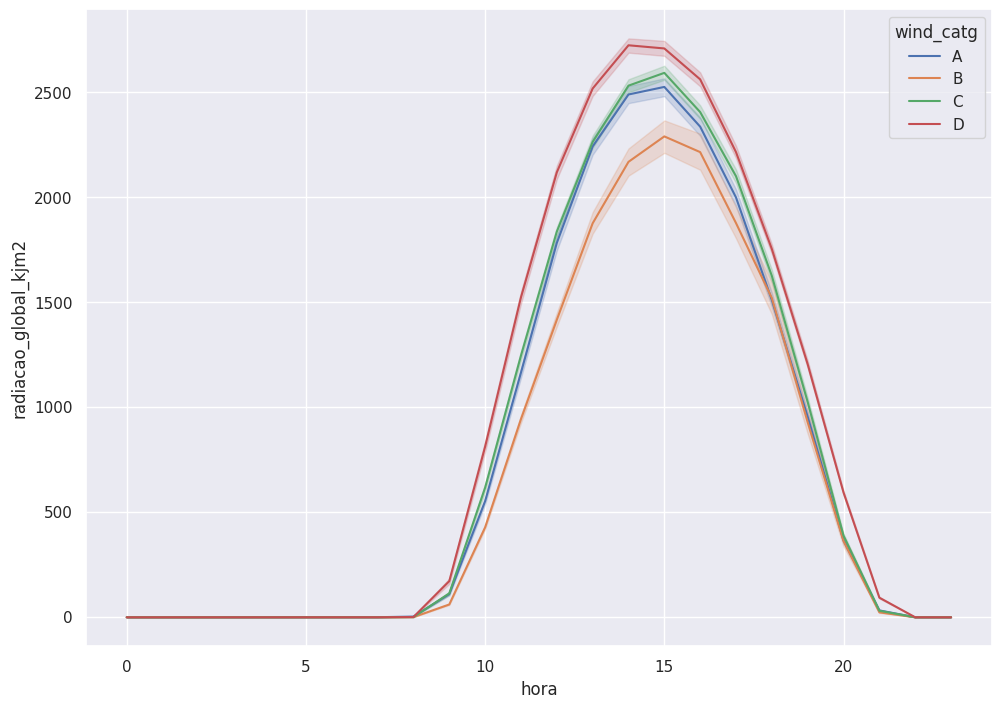

In [375]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### By hour with atmo press as hue

In [376]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", df_hour_press)

[961.6 970.7 972.5 974.5 981.5]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

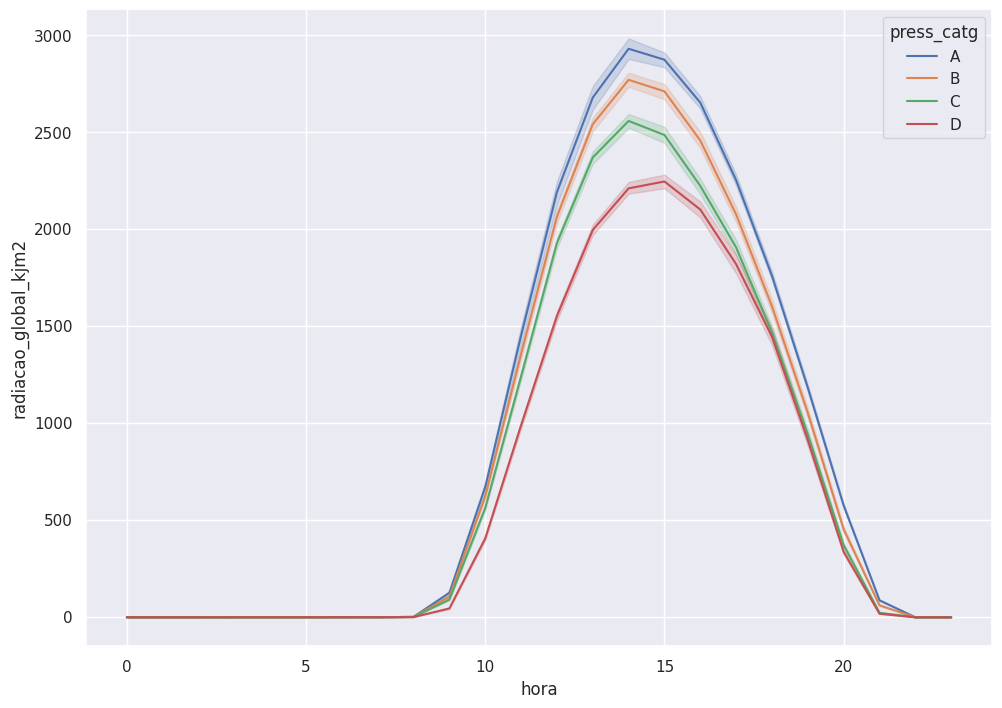

In [377]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

# A871
Again, randomly getting this station from Paraná (PR)

In [378]:
print(dict_data["A871"][0])

Nome: JAPIRA
Codigo Estacao: A871
Latitude: -23.77333332
Longitude: -50.18055554
Altitude: 692.88
Situacao: Operante
Data Inicial: 2008-02-28
Data Final: 2023-09-10
Periodicidade da Medicao: Horaria




### Renaming

In [379]:
df_a871 = renameDatasetColumns(load(dict_data["A871"][1]))

### Showing info data

In [380]:
df_a871.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136176 entries, 0 to 136175
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   data_medicao                                        136176 non-null  object 
 1   hora_medicao                                        136176 non-null  int64  
 2   precipitacao_total_horario_mm                       122820 non-null  float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  123047 non-null  float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    123037 non-null  float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          122997 non-null  float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          122997 non-null  float64
 7   radiacao_global_kjm2                                122936 non-null  float64
 8   temperatura_da_cpu_da_estacao_c                     123047 non-n

In [381]:
df_a871.describe().T

,count,mean,std,min,25%,50%,75%,max
hora_medicao,136176.0,1150.000000,692.221197,0.000000,575.000000,1150.00000,1725.000000,2300.000000
precipitacao_total_horario_mm,122820.0,0.153594,1.169212,0.000000,0.000000,0.00000,0.000000,54.400000
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,123047.0,936.540914,3.600613,923.000000,934.000000,936.40000,939.000000,950.400000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,123037.0,1015.423322,4.654935,999.727749,1012.122474,1015.08605,1018.569869,1031.803242
pressao_atmosferica_max_na_hora_ant_aut_mb,122997.0,936.800829,3.576994,923.000000,934.300000,936.60000,939.200000,950.500000
pressao_atmosferica_min_na_hora_ant_aut_mb,122997.0,936.280857,3.615781,922.800000,933.800000,936.10000,938.700000,950.200000
radiacao_global_kjm2,122936.0,731.307680,1048.128858,-6.957000,-3.540000,28.62550,1349.682250,4240.856000
temperatura_da_cpu_da_estacao_c,123047.0,21.956374,5.339529,1.000000,18.000000,22.00000,25.000000,40.000000
temperatura_do_ar_bulbo_seco_horaria_c,123047.0,20.428519,4.759697,0.100000,17.300000,20.30000,23.500000,37.300000
temperatura_do_ponto_de_orvalho_c,122885.0,14.716195,4.125516,-10.000000,12.100000,15.20000,18.000000,24.100000


In [382]:
(df_a871.isnull().sum()/(len(df_a871)))*100

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                          9.807896
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb     9.641200
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb       9.648543
pressao_atmosferica_max_na_hora_ant_aut_mb             9.677917
pressao_atmosferica_min_na_hora_ant_aut_mb             9.677917
radiacao_global_kjm2                                   9.722712
temperatura_da_cpu_da_estacao_c                        9.641200
temperatura_do_ar_bulbo_seco_horaria_c                 9.641200
temperatura_do_ponto_de_orvalho_c                      9.760163
temperatura_maxima_na_hora_ant_aut_c                   9.677917
temperatura_minima_na_hora_ant_aut_c                   9.677917
temperatura_orvalho_max_na_hora_ant_aut_c              9.696275
temperatura_orvalho_min_na_hora_ant_aut_c             10.227206
tensao_da_bateria_da_estacao_v          

### Removing nulls

In [383]:
df_a871_non_null = removeNulls(df_a871, "radiacao_global_kjm2")

### Creating datetime features

In [384]:
df_a871_non_null_dt = create_datetime_feature(df_a871_non_null)
df_a871_non_null_dt = create_split_date_features(df_a871_non_null_dt)

### Showing the data

In [385]:
df_a871_non_null_dt.head().T

,25,26,27,28,29
data_medicao,2008-02-29,2008-02-29,2008-02-29,2008-02-29,2008-02-29
hora_medicao,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00
precipitacao_total_horario_mm,0.8,0.8,0.8,0.8,0.0
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,932.7,932.9,932.7,932.1,931.5
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,1011.409854,1011.851186,1011.718743,1011.124296,1010.529858
pressao_atmosferica_max_na_hora_ant_aut_mb,932.7,932.9,932.9,932.7,932.1
pressao_atmosferica_min_na_hora_ant_aut_mb,932.2,932.6,932.7,932.1,931.5
radiacao_global_kjm2,-3.527,-3.383,-2.833,-2.922,-2.955
temperatura_da_cpu_da_estacao_c,23.0,22.0,21.0,21.0,21.0
temperatura_do_ar_bulbo_seco_horaria_c,19.8,19.0,18.7,18.5,18.3


### Date analisys

In [386]:
df = df_a871_non_null_dt

#### By year

In [387]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Mean and STD

In [388]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2008,707.483490,1026.099081
2009,694.780635,1020.857893
2010,700.704280,1031.915441
2011,744.019718,1062.950002
2012,794.828669,1093.355462
2013,717.578724,1040.381266
2014,783.557360,1078.037383
2015,690.888158,1010.071874
2016,736.298138,1060.131357


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

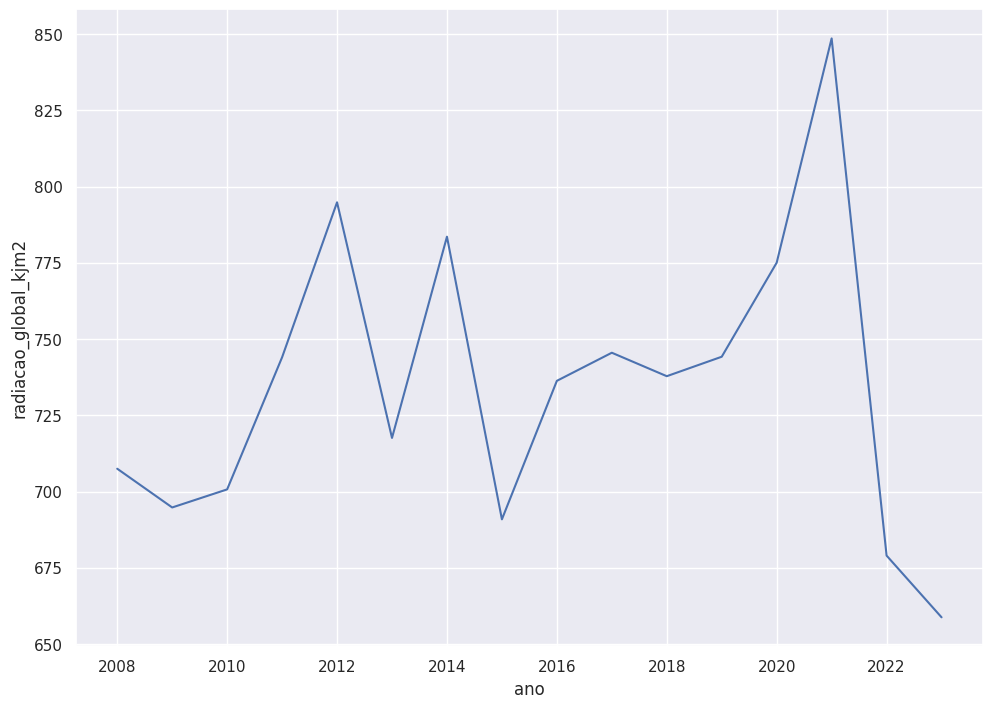

In [397]:
sns.lineplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### By month

In [390]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

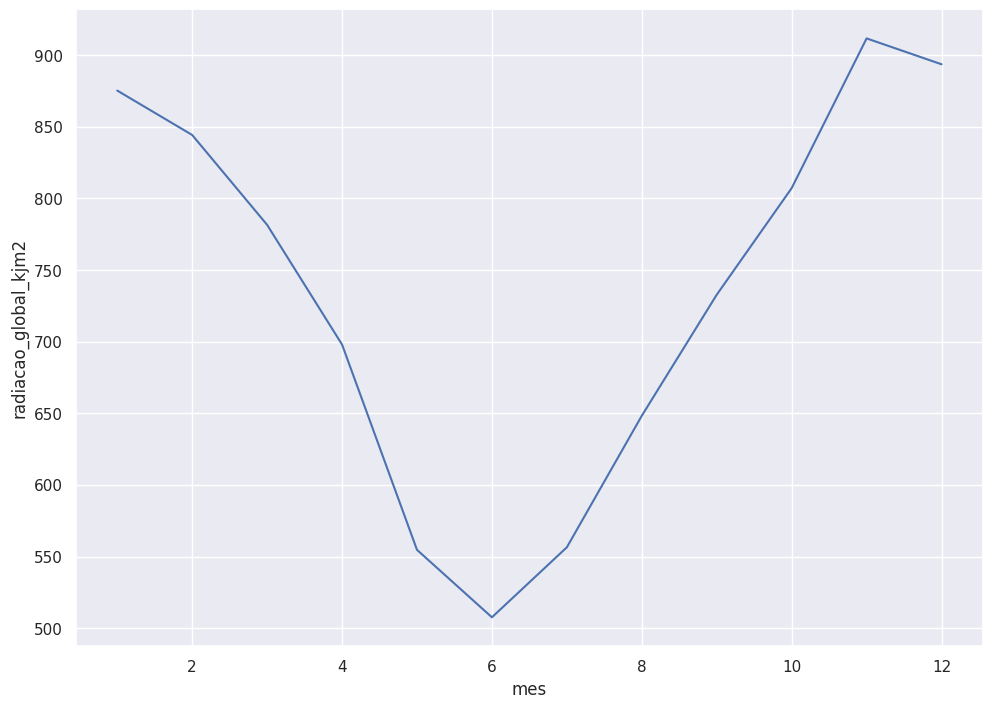

In [391]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### By hour

In [392]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

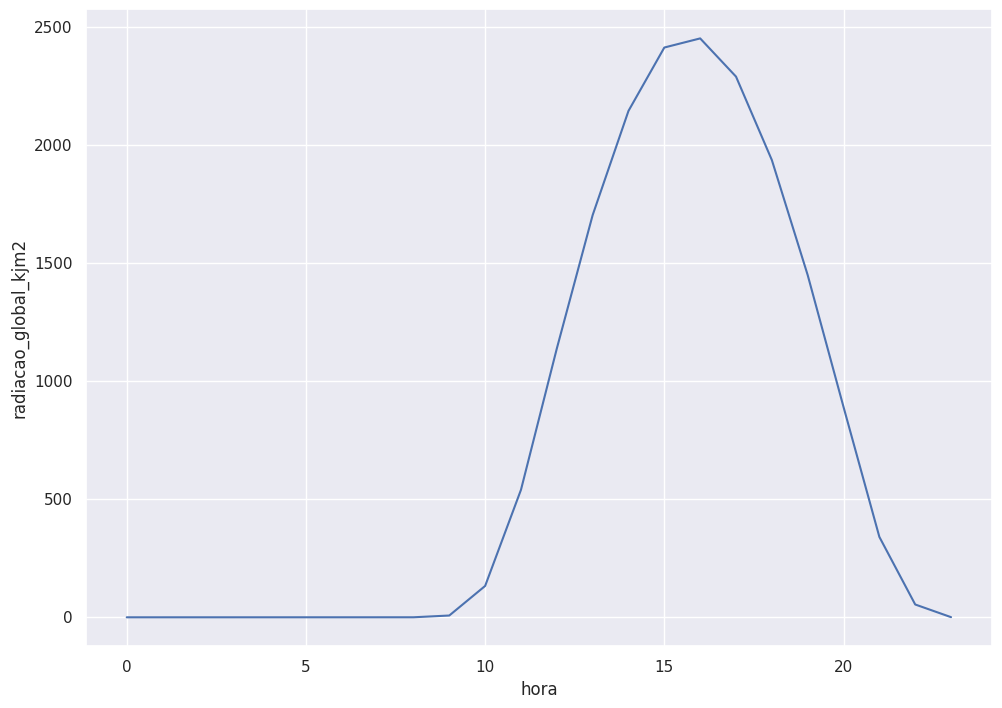

In [393]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### By hour with wind as hue

In [398]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_rajada_maxima_ms"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_rajada_maxima_ms", df_hour_wind)

[ 0.   3.1  5.1  6.9 32.2]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

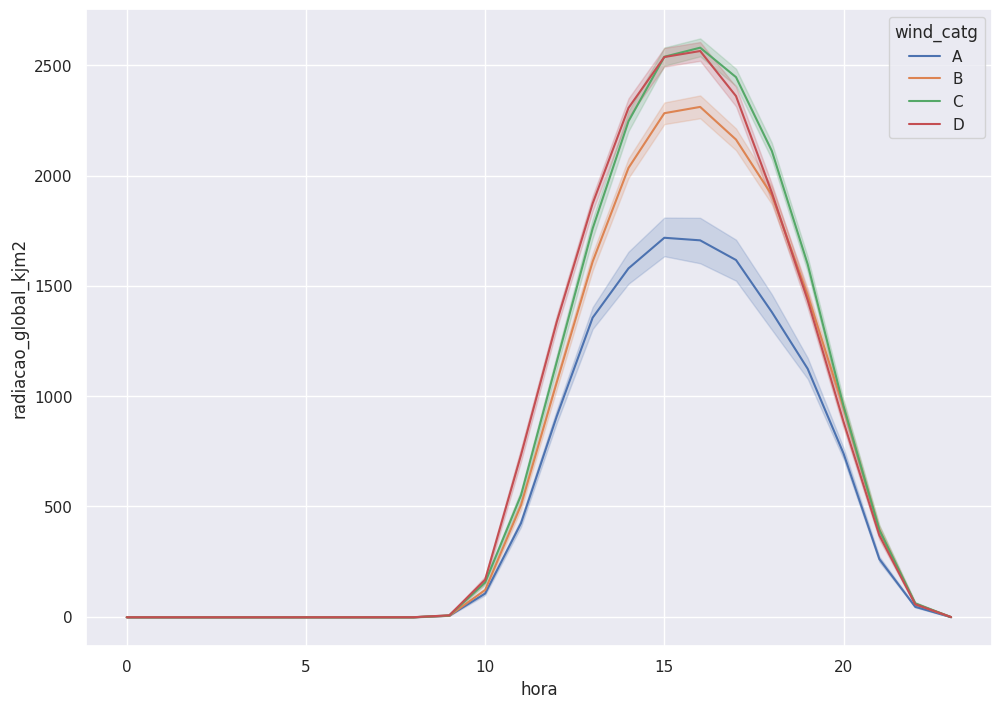

In [399]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### By hour with atmo press as hue

In [ ]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", df_hour_press)

In [ ]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

# A127
Randomly getting this station from Amazonas (AM)

In [407]:
print(dict_data["A127"][0])

Nome: NOVO AIRAO
Codigo Estacao: A127
Latitude: -2.628982
Longitude: -60.941108
Altitude: 37.59
Situacao: Desativada
Data Inicial: 2008-04-10
Data Final: 2008-10-29
Periodicidade da Medicao: Horaria




### Renaming

In [409]:
df_a127 = renameDatasetColumns(load(dict_data["A127"][1]))

### Showing info data

In [412]:
df_a127.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   data_medicao                                        4872 non-null   object 
 1   hora_medicao                                        4872 non-null   int64  
 2   precipitacao_total_horario_mm                       3102 non-null   float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  3102 non-null   float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    3102 non-null   float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          3102 non-null   float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          3102 non-null   float64
 7   radiacao_global_kjm2                                3102 non-null   float64
 8   temperatura_da_cpu_da_estacao_c                     3102 non-null   float64
 9

In [413]:
df_a127.describe().T

,count,mean,std,min,25%,50%,75%,max
hora_medicao,4872.0,1150.000000,692.289707,0.000000,575.000000,1150.000000,1725.000000,2300.000000
precipitacao_total_horario_mm,3102.0,0.268279,1.825363,0.000000,0.000000,0.000000,0.000000,35.600000
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,3102.0,1006.133011,1.924668,1000.100000,1004.800000,1006.200000,1007.500000,1012.000000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,3102.0,1010.632615,1.942950,1004.581249,1009.311663,1010.723753,1012.035321,1016.543713
pressao_atmosferica_max_na_hora_ant_aut_mb,3102.0,1006.441167,1.889668,1000.700000,1005.200000,1006.600000,1007.800000,1012.100000
pressao_atmosferica_min_na_hora_ant_aut_mb,3102.0,1005.823533,1.928416,1000.000000,1004.500000,1005.900000,1007.200000,1011.900000
radiacao_global_kjm2,3102.0,717.921990,1039.590486,-3.540000,-3.472000,4.332000,1270.254500,3619.887000
temperatura_da_cpu_da_estacao_c,3102.0,27.763378,3.369070,22.000000,25.000000,27.000000,30.000000,38.000000
temperatura_do_ar_bulbo_seco_horaria_c,3102.0,26.298485,2.585005,21.700000,24.300000,25.600000,27.900000,35.200000
temperatura_do_ponto_de_orvalho_c,3102.0,23.098130,0.871308,18.300000,22.600000,23.200000,23.700000,25.600000


In [414]:
(df_a127.isnull().sum()/(len(df_a127)))*100

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                         36.330049
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb    36.330049
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb      36.330049
pressao_atmosferica_max_na_hora_ant_aut_mb            36.330049
pressao_atmosferica_min_na_hora_ant_aut_mb            36.330049
radiacao_global_kjm2                                  36.330049
temperatura_da_cpu_da_estacao_c                       36.330049
temperatura_do_ar_bulbo_seco_horaria_c                36.330049
temperatura_do_ponto_de_orvalho_c                     36.330049
temperatura_maxima_na_hora_ant_aut_c                  36.330049
temperatura_minima_na_hora_ant_aut_c                  36.330049
temperatura_orvalho_max_na_hora_ant_aut_c             36.330049
temperatura_orvalho_min_na_hora_ant_aut_c             36.330049
tensao_da_bateria_da_estacao_v          

In [421]:
# A203 Proximo

In [425]:
df_a316_non_null_dt.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitacao_total_horario_mm,113994.0,0.058545,0.0,0.0,0.0,0.0,55.8,0.859526
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,120257.0,992.947482,983.6,991.3,993.0,994.7,1001.2,2.477146
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,120247.0,1012.57832,1002.673769,1010.856286,1012.632226,1014.43419,1021.063821,2.670703
pressao_atmosferica_max_na_hora_ant_aut_mb,120079.0,993.254154,984.0,991.6,993.3,994.9,1001.2,2.432824
pressao_atmosferica_min_na_hora_ant_aut_mb,120079.0,992.668084,983.5,991.0,992.7,994.4,1001.0,2.488053
radiacao_global_kjm2,120257.0,1027.399741,-7.02,-3.54,191.948,2114.761,4246.893,1247.990849
temperatura_da_cpu_da_estacao_c,119497.0,30.482255,19.0,27.0,30.0,34.0,44.0,4.688791
temperatura_do_ar_bulbo_seco_horaria_c,120257.0,28.527212,18.3,25.1,27.9,31.8,39.5,4.070311
temperatura_do_ponto_de_orvalho_c,120257.0,17.626213,2.2,15.7,17.9,19.9,26.3,3.214692
temperatura_maxima_na_hora_ant_aut_c,120079.0,29.193496,18.9,25.5,28.7,32.7,40.1,4.252992
